## Import

In [1]:
from gemseo import generate_coupling_graph
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

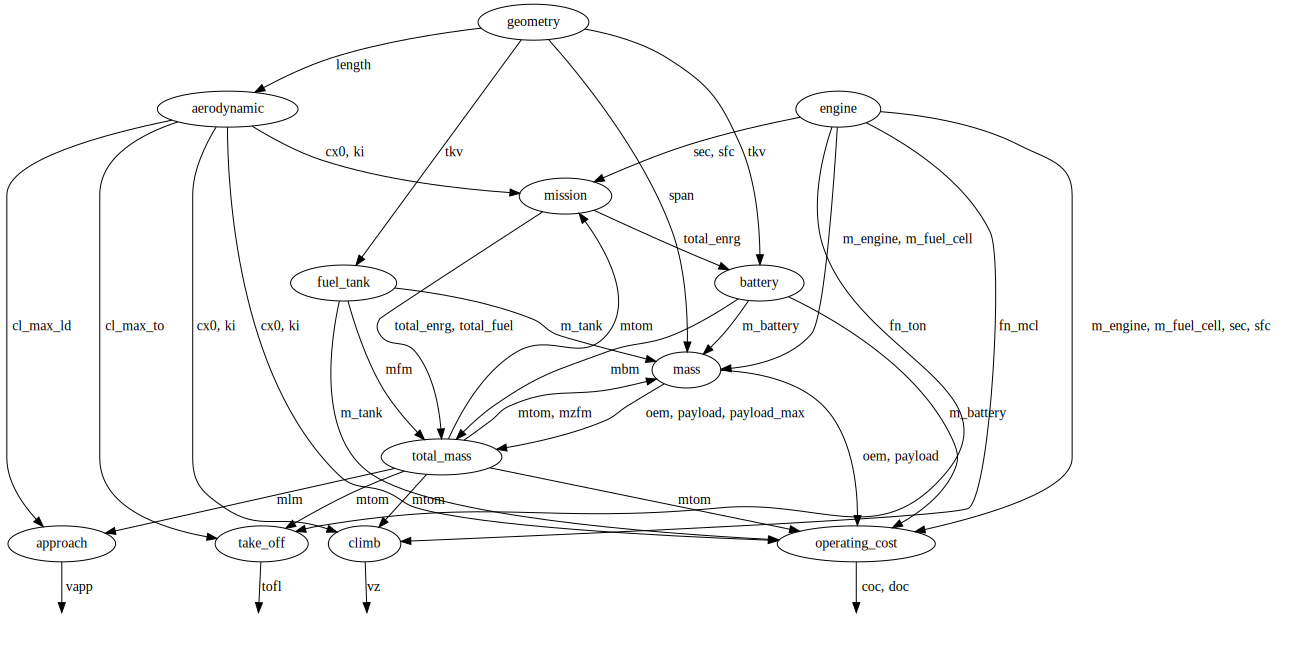

In [4]:
generate_coupling_graph(disciplines)

## Design Space

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [6]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs
design_space = ParameterSpace()
design_space.add_variable("slst", lower_bound=convert_from("kN", 100), upper_bound=convert_from("kN", 200), value=convert_from("kN", 150))
design_space.add_variable("n_pax", lower_bound=120, upper_bound=180, value=150)
design_space.add_variable("area", lower_bound=convert_from("m2", 100), upper_bound=convert_from("m2", 200), value=convert_from("m2", 180))
design_space.add_variable("ar", lower_bound=5, upper_bound=20, value=9)



design_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
design_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
design_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



## Scenario

In [7]:
scenario = MDOScenario(disciplines, "mtom", design_space, formulation_name="MDF")

In [8]:
scenario.add_constraint("tofl", constraint_type="ineq", positive=False, value=1900.)
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=40.0)
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=45.0)
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0.0)

In [9]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=20)


    INFO - 14:33:10: *** Start MDOScenario execution ***
    INFO - 14:33:10: MDOScenario
    INFO - 14:33:10:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:33:10:    MDO formulation: MDF
    INFO - 14:33:10: Optimization problem:
    INFO - 14:33:10:    minimize mtom(slst, n_pax, area, ar, aef, cef, sef)
    INFO - 14:33:10:    with respect to aef, ar, area, cef, n_pax, sef, slst
    INFO - 14:33:10:    subject to constraints:
    INFO - 14:33:10:       tofl(slst, n_pax, area, ar, aef, cef, sef) <= 1900.0
    INFO - 14:33:10:       vapp(slst, n_pax, area, ar, aef, cef, sef) <= 69.44999999400001
    INFO - 14:33:10:       vz(slst, n_pax, area, ar, aef, cef, sef) >= 1.524
    INFO - 14:33:10:       span(slst, n_pax, area, ar, aef, cef, sef) <= 40.0
    INFO - 14:33:10:       length(slst, n_pax, area, ar, aef, cef, sef) <= 45.0
    INFO - 14:33:10:       fm(slst, n_pax, area, ar, aef, cef, sef) >

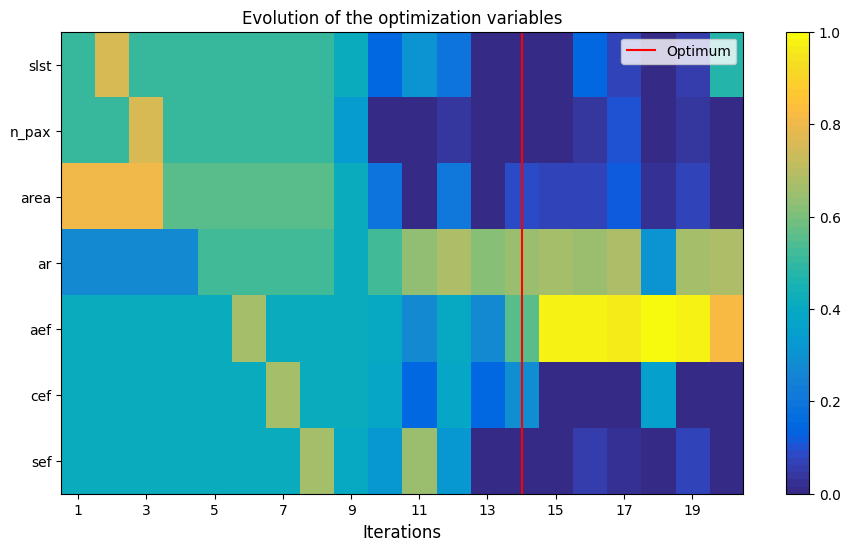

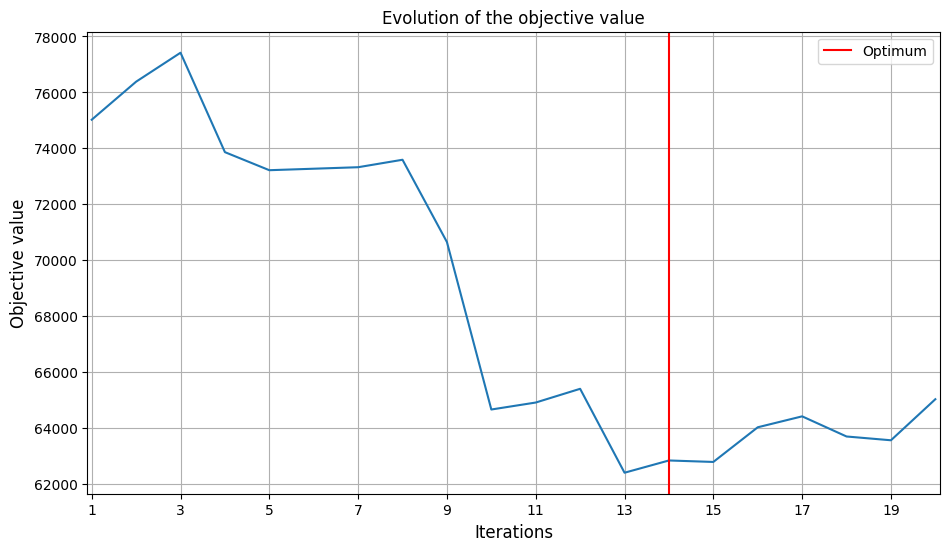

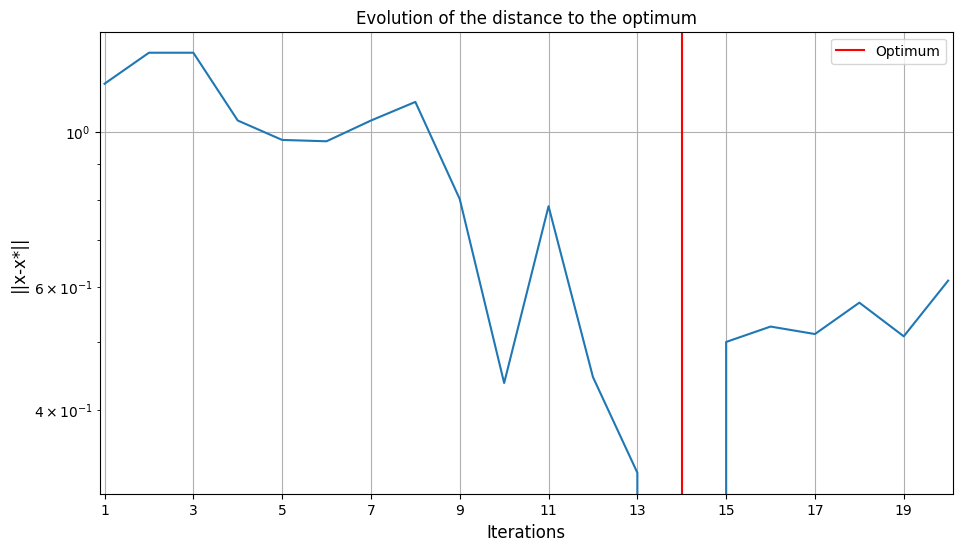

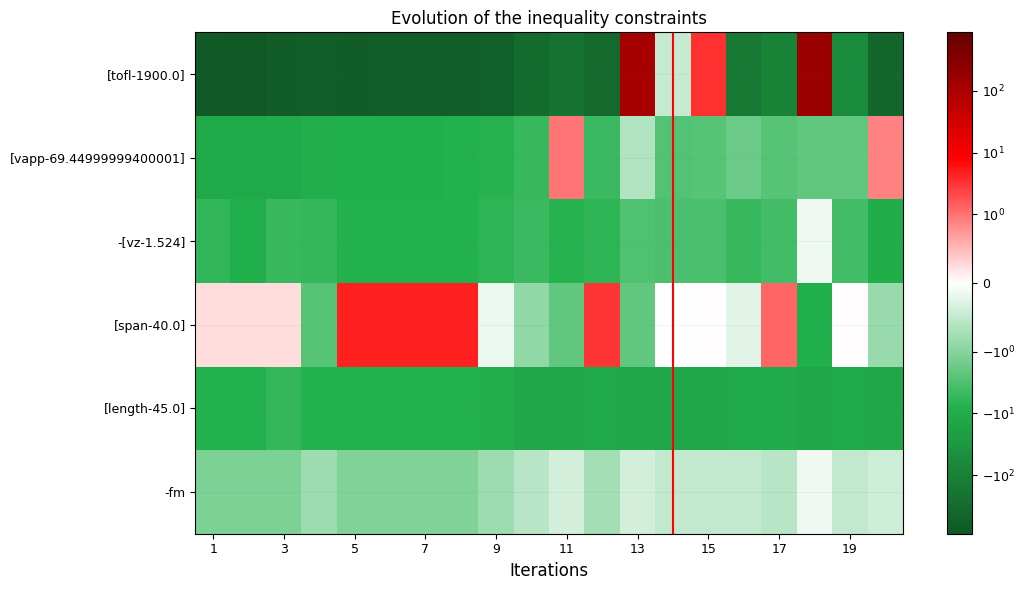

In [10]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)


# Surogate

In [11]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [12]:
training_dataset = sample_disciplines(disciplines, design_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, design_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_FULLFACT", n_samples=20)

    INFO - 14:33:12: *** Start Sampling execution ***
    INFO - 14:33:12: Sampling
    INFO - 14:33:12:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:33:12:    MDO formulation: MDF
    INFO - 14:33:12: Running the algorithm OT_OPT_LHS:
    INFO - 14:33:12:    100%|██████████| 20/20 [00:00<00:00, 54.98 it/sec]
    INFO - 14:33:12: *** End Sampling execution (time: 0:00:00.386153) ***
    INFO - 14:33:12: *** Start Sampling execution ***
    INFO - 14:33:12: Sampling
    INFO - 14:33:12:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:33:12:    MDO formulation: MDF
    INFO - 14:33:12: Running the algorithm OT_FULLFACT:
    INFO - 14:33:12:    100%|██████████| 1/1 [00:00<00:00, 63.58 it/sec]oes not exist; use 1 samples instead, i.e. the largest 7-th integer power less than 20.
    INFO - 14:33:12: *** End 

In [13]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [14]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [15]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.86418949]),
 'length': array([0.96076427]),
 'mtom': array([0.86687255]),
 'span': array([0.91006397]),
 'tofl': array([0.91823409]),
 'vapp': array([0.931635]),
 'vz': array([0.88596868])}

In [16]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([0.11831416]),
 'length': array([0.06878128]),
 'mtom': array([361.55025806]),
 'span': array([2.14034162]),
 'tofl': array([126.73970136]),
 'vapp': array([0.2104813]),
 'vz': array([1.37778833])}

In [17]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.23042998]),
 'length': array([0.58101491]),
 'mtom': array([1318.88239623]),
 'span': array([2.72984787]),
 'tofl': array([85.74901789]),
 'vapp': array([1.44090623]),
 'vz': array([1.53144125])}

In [18]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", design_space, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False, value=1900.)
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=40.0)
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=45.0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0.0)

 WARNING - 14:33:13: No coupling in MDA, switching chain_linearize to True.


In [19]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 14:33:13: *** Start MDOScenario execution ***
    INFO - 14:33:13: MDOScenario
    INFO - 14:33:13:    Disciplines: RBF_Sampling
    INFO - 14:33:13:    MDO formulation: MDF
    INFO - 14:33:13: Optimization problem:
    INFO - 14:33:13:    minimize mtom(slst, n_pax, area, ar, aef, cef, sef)
    INFO - 14:33:13:    with respect to aef, ar, area, cef, n_pax, sef, slst
    INFO - 14:33:13:    subject to constraints:
    INFO - 14:33:13:       tofl(slst, n_pax, area, ar, aef, cef, sef) <= 1900.0
    INFO - 14:33:13:       vapp(slst, n_pax, area, ar, aef, cef, sef) <= 69.44999999400001
    INFO - 14:33:13:       vz(slst, n_pax, area, ar, aef, cef, sef) >= 1.524
    INFO - 14:33:13:       span(slst, n_pax, area, ar, aef, cef, sef) <= 40.0
    INFO - 14:33:13:       length(slst, n_pax, area, ar, aef, cef, sef) <= 45.0
    INFO - 14:33:13:       fm(slst, n_pax, area, ar, aef, cef, sef) >= 0.0
    INFO - 14:33:13:    over the design space:
    INFO - 14:33:13:       +-------+-------

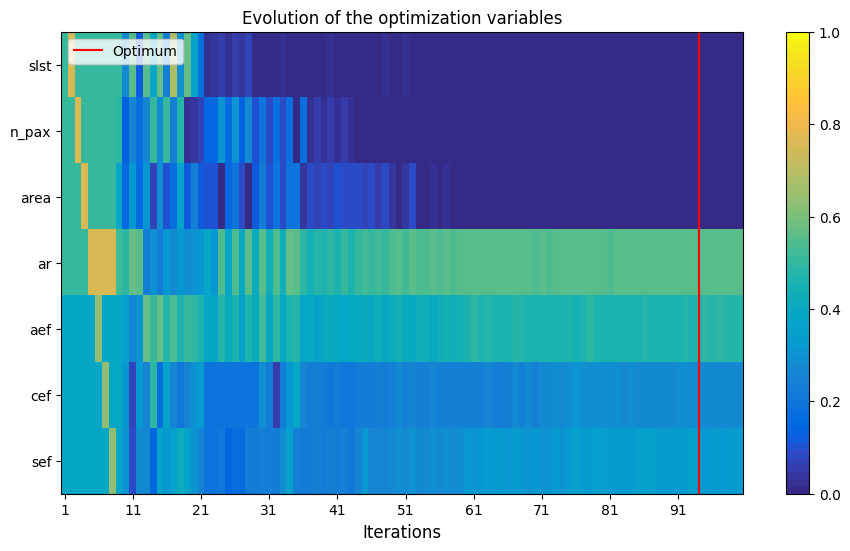

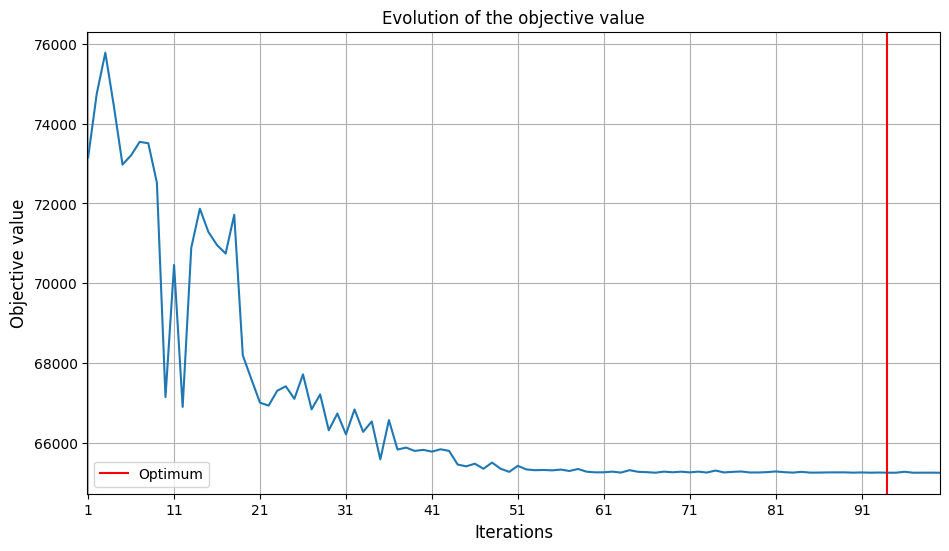

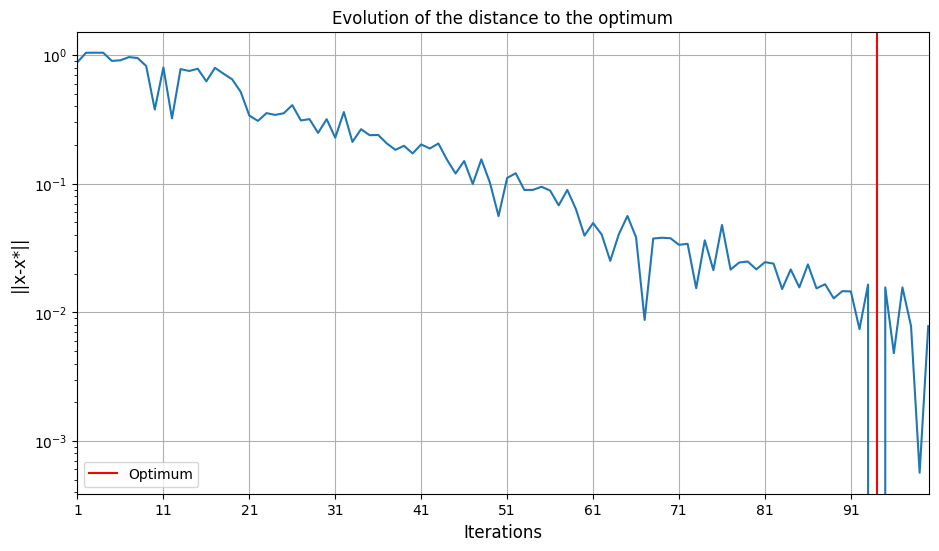

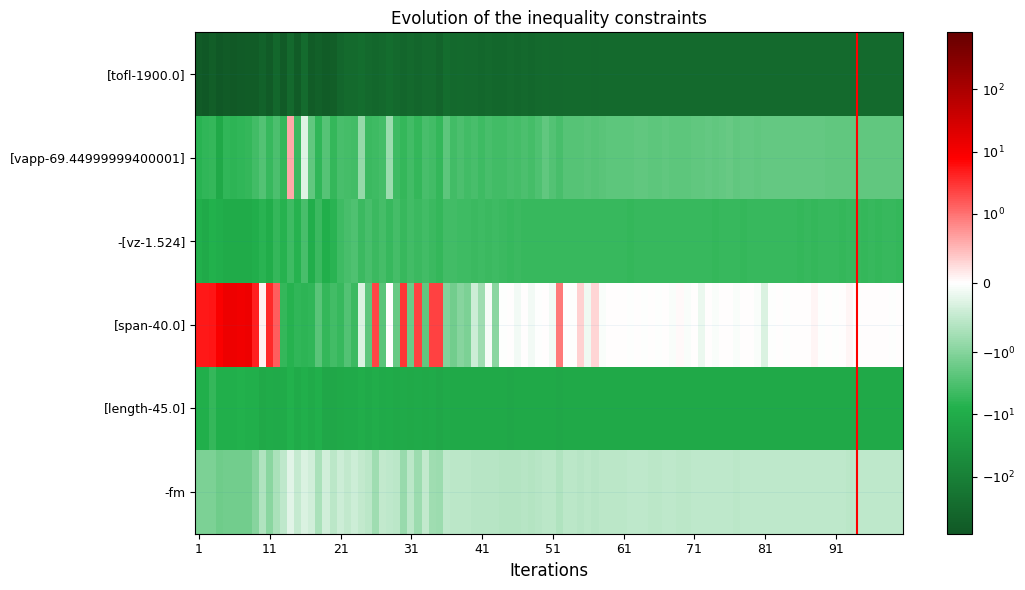

In [20]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluation de la solution optimale du surogate

In [21]:
xopt = scenario_surrogate.optimization_result.x_opt.reshape(1, -1)
scenario.execute(algo_name="CustomDOE", samples = xopt)

    INFO - 14:33:15: *** Start MDOScenario execution ***
    INFO - 14:33:15: MDOScenario
    INFO - 14:33:15:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:33:15:    MDO formulation: MDF
    INFO - 14:33:15: Optimization problem:
    INFO - 14:33:15:    minimize mtom(slst, n_pax, area, ar, aef, cef, sef)
    INFO - 14:33:15:    with respect to aef, ar, area, cef, n_pax, sef, slst
    INFO - 14:33:15:    subject to constraints:
    INFO - 14:33:15:       tofl(slst, n_pax, area, ar, aef, cef, sef) <= 1900.0
    INFO - 14:33:15:       vapp(slst, n_pax, area, ar, aef, cef, sef) <= 69.44999999400001
    INFO - 14:33:15:       vz(slst, n_pax, area, ar, aef, cef, sef) >= 1.524
    INFO - 14:33:15:       span(slst, n_pax, area, ar, aef, cef, sef) <= 40.0
    INFO - 14:33:15:       length(slst, n_pax, area, ar, aef, cef, sef) <= 45.0
    INFO - 14:33:15:       fm(slst, n_pax, area, ar, aef, cef, sef) >

**Visualisation de l'avion final**

In [22]:
from gemseo_oad_training.utils import draw_aircraft

In [28]:
dict_result = scenario_surrogate.optimization_result.x_opt_as_dict

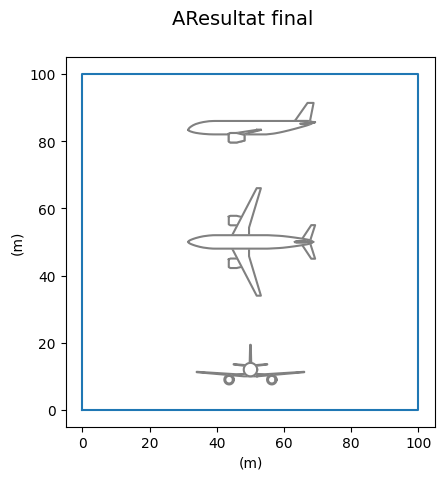

In [ ]:
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0], title="Résultat final")